In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter


# **Read Data**

In [2]:
df = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
df = shuffle(df)

In [3]:
df.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
95,53,1,0,142,226,0,0,111,1,0.0,2,0,3,1
185,44,1,0,112,290,0,0,153,0,0.0,2,1,2,0


In [5]:
data = df.drop(columns=['output'])
target = df['output']

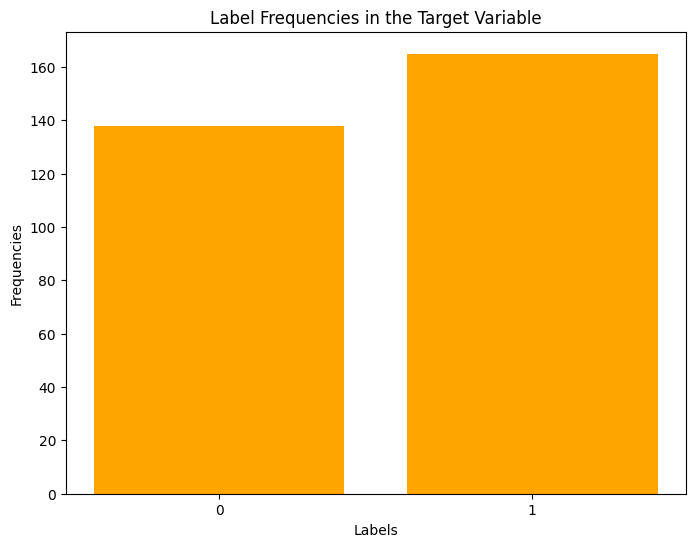

In [60]:
counter = Counter(target)
freqs = list(counter.values())
labels = list(counter.keys())

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, freqs, color='orange')
plt.xticks(labels)  # Set x-ticks to be the labels
plt.xlabel('Labels')
plt.ylabel('Frequencies')
plt.title('Label Frequencies in the Target Variable')
plt.show()

**Preprocess Data**

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [6]:
scaler = StandardScaler()
data = scaler.fit_transform(data)


In [7]:
data.shape

(303, 13)

# **Use Linear Discriminant Analysis as Feature Reduction Method**

In [8]:
class LinearDiscriminantAnalysis:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        
    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        n_classes = len(class_labels)
        class_means = np.zeros((n_classes, n_features))
        
        # Compute class means
        for idx, label in enumerate(class_labels):
            class_means[idx, :] = np.mean(X[y == label], axis=0)
        
        # Compute within-class scatter matrix (Sw)
        S_w = np.zeros((n_features, n_features))
        for idx, label in enumerate(class_labels):
            class_samples = X[y == label]
            centered_samples = class_samples - class_means[idx]
            S_w += np.dot(centered_samples.T, centered_samples)
        
        # Compute between-class scatter matrix (Sb)
        overall_mean = np.mean(X, axis=0)
        S_b = np.zeros((n_features, n_features))
        for idx, label in enumerate(class_labels):
            n_samples = len(X[y == label])
            mean_diff = class_means[idx, :] - overall_mean
            S_b += n_samples * np.outer(mean_diff, mean_diff)
    
        # Solve eigenvalue problem for S_w^-1 * S_b
        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(S_w).dot(S_b))  # Use pseudo-inverse to handle singular S_w
        
        # Only keep the real part of eigenvalues and eigenvectors
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)
        
        # Sort the eigenvalues and corresponding eigenvectors in descending order
        eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
        eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)
        
        # Select the top n_components eigenvectors
        self.linear_discriminants = np.array([eigen_pair[1] for eigen_pair in eigen_pairs[:self.n_components]]).T

    def transform(self, X):
        # Project data onto the linear discriminants
        return np.dot(X, self.linear_discriminants)

num_components = 10  # Number of components to keep
lda = LinearDiscriminantAnalysis(n_components=num_components)
lda.fit(data, target)
data_reduced = lda.transform(data)


In [9]:
data_reduced

array([[ 0.45013747, -0.4310704 ,  1.3525902 , ...,  1.77909825,
         0.29608659, -0.71105968],
       [-1.37304083,  0.36213239, -1.28700811, ...,  0.6550799 ,
        -0.1613543 , -0.73532359],
       [ 0.0335896 , -0.44076504, -1.18341777, ...,  1.23723121,
        -0.72548611, -0.69583296],
       ...,
       [-1.21407262, -0.44821669,  1.28263143, ..., -0.55426269,
        -0.91132317,  0.41196427],
       [ 0.07861485, -0.95876441,  0.79251918, ...,  0.93734474,
         0.44924512, -0.03947599],
       [-2.75174962, -2.04561095, -0.85524375, ..., -0.06244444,
        -0.58863242, -0.02524612]])

In [10]:
data_reduced.shape

(303, 10)

# **Use Swarm Optimization Technique for Feature Selection**

In [11]:
class Particle:
    def __init__(self, num_features):
        self.position = np.random.choice([0, 1], size=num_features)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=num_features)
        self.best_position = self.position.copy()
        self.best_fitness = float('-inf')

def fitness_function(features, X, y):
    # Evaluate fitness using cross-validation with random forest classifier
    selected_features = X[:, features == 1]
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, selected_features, y, cv=5)
    return np.mean(scores)

def particle_swarm_optimization(X, y, num_particles, num_iterations):
    num_features = X.shape[1]
    swarm = [Particle(num_features) for _ in range(num_particles)]
    global_best_position = None
    global_best_fitness = float('-inf')

    for _ in range(num_iterations):
        for particle in swarm:
            fitness = fitness_function(particle.position, X, y)
            if fitness > particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position.copy()

            if fitness > global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle.position.copy()

            # Update velocity and position
            inertia_weight = 0.5
            cognitive_constant = 1.5
            social_constant = 1.5
            rand1 = np.random.rand(num_features)
            rand2 = np.random.rand(num_features)
            particle.velocity = (inertia_weight * particle.velocity +
                                 cognitive_constant * rand1 * (particle.best_position - particle.position) +
                                 social_constant * rand2 * (global_best_position - particle.position))
            particle.position = (particle.position + particle.velocity > 0).astype(int)

    return global_best_position

selected_features = particle_swarm_optimization(data_reduced,target, num_particles=20, num_iterations=10)


In [22]:
selected_features

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 1])

In [23]:
data_selected = data_reduced[:, selected_features == 1]


In [25]:
data_selected.shape

(303, 6)

# **Spilt Data set into Train set and Test set**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_selected,target, test_size=0.2, random_state=42)

# **Implement Logisitic Regression Classifier**

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def logisticRegression(x, y):
    n, m = x.shape
    w = np.zeros(m)
    b = 0
    lamda = 0.1
    l = 0.001
    iterations = 500000
    for i in range(iterations):
        linear_model = np.dot(x, w) + b
        y_pred = sigmoid(linear_model)
        MSE = np.sum((y - y_pred) ** 2) / n + lamda * np.sum(w ** 2)
        Dw1 = -(2 / n) * np.dot(x.T, (y - y_pred)) + (lamda / n) * w
        Db = -(2 / n) * np.sum(y - y_pred)
        w -= l * Dw1
        b -= l * Db
        if i % 100000 == 0:
            print("w: {}  b: {}  cost: {}  iter: {}".format(w, b, MSE, i))
    return w, b

def predict(x, w, b):
    linear_model = np.dot(x, w) + b
    y_pred = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_pred]

In [34]:
w, b = logisticRegression(x_train, y_train)
predictions = predict(x_test, w, b)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

w: [ 1.04986857e-03  4.32839334e-06  1.21785471e-05  4.19419950e-05
  5.35746068e-05 -4.72105740e-05]  b: 0.00010743801652892563  cost: 0.25  iter: 0
w: [ 1.84367161e+00 -3.34100969e-02  1.80636829e-03 -5.29091838e-02
  2.29319608e-01 -9.53704099e-02]  b: 0.12798625563685195  cost: 0.4570289338994162  iter: 100000
w: [ 1.84480107 -0.03439685 -0.00673925 -0.11755567  0.2918426  -0.08996171]  b: 0.12822156738583151  cost: 0.46172216682134315  iter: 200000
w: [ 1.84539427 -0.03483642 -0.0106843  -0.14736538  0.32067841 -0.08746141]  b: 0.12833727849506216  cost: 0.4644680852741867  iter: 300000
w: [ 1.8456831  -0.03503752 -0.01250309 -0.16109574  0.33395669 -0.08631484]  b: 0.12839112135478647  cost: 0.46585632312231084  iter: 400000
Accuracy: 0.8524590163934426


# **Print Confusion Matrix**

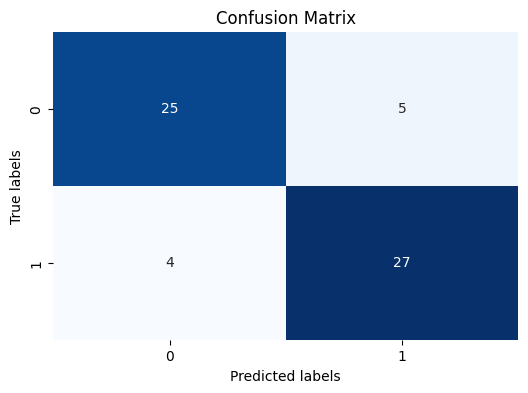

In [48]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, predictions)
# Print the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# **Print Classification Report**

In [49]:
# Optionally, print a detailed classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.84      0.87      0.86        31

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



# **Built-in LogisticRegression Classifier**

In [36]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train,y_train)

LogisticRegression()

In [37]:
accuracy = classifier.score(x_test, y_test)
print("Accuracy using selected features:", accuracy)

Accuracy using selected features: 0.8524590163934426


# **Built-in Random Forest Classifier**

In [28]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [29]:
accuracy = clf.score(x_test, y_test)
print("Accuracy using selected features:", accuracy)

Accuracy using selected features: 0.8688524590163934
